In [75]:
import geemap
import ee
import geedim
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix,cohen_kappa_score,accuracy_score
import numpy as np;
import polars as pl
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
## TODO : Import datasets
sampling = pd.read_csv("sampling_Antrema_2024.csv",index_col=0)## mettre la colonne 0 sou forme indexing
sampling.drop(columns=[".geo"],inplace=True)
## !! split the data into train and test sets
x = sampling.drop(columns=["LULC"])
y = sampling["LULC"]

#Set the parameters for train_test_split
splitting = 0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=splitting, random_state=42, stratify=y)

c:\Users\cepf_\anaconda3\envs\geo\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\cepf_\anaconda3\envs\geo\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Bandes sélectionnées selon moyenne: ['B11', 'B2', 'B3', 'B4', 'EVI', 'MNDWI', 'NDVI', 'NDVI_MAX', 'NDWI', 'SAVI']
Bandes sélectionnées selon la mediane: ['B11', 'B2', 'B3', 'B4', 'EVI', 'MNDWI', 'NDVI', 'NDVI_MAX', 'NDWI', 'SAVI']


C:\Users\cepf_\AppData\Local\Temp\ipykernel_22352\4251012764.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df, x='Feature', y='Importance', palette='viridis')


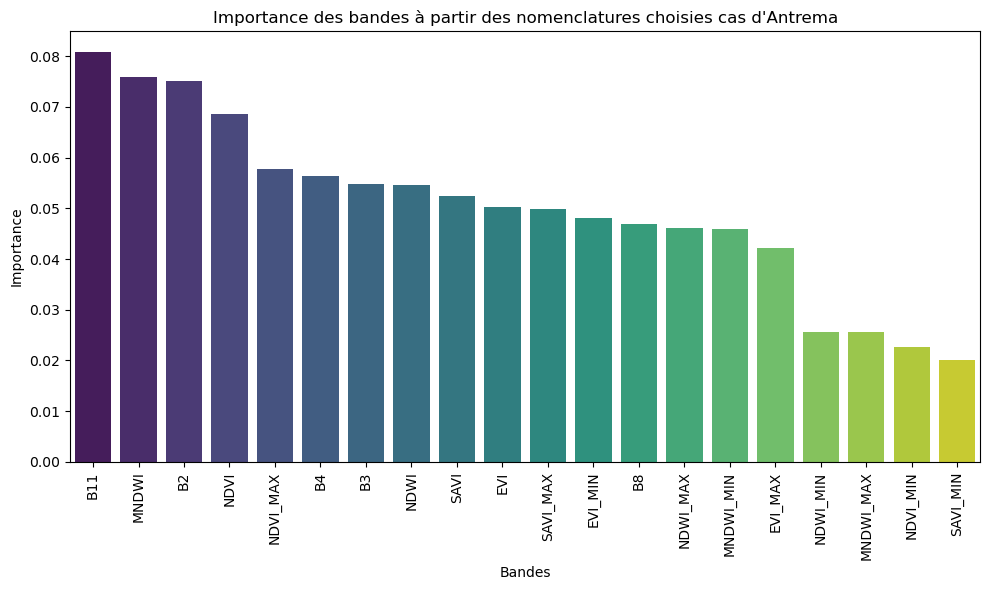

In [93]:
#!! creerr le modele random forest/  mais on pourrait ustiliser si pouura d'autres algorithme tels que SVm si besoin
ref_models = RandomForestClassifier(n_estimators=100, random_state=42)
# fittingm models
fitting_results = ref_models.fit(x, y)
# Selection des variabbles
# Sélection automatique en fonction de l'importance des variables
selector_mean = SelectFromModel(fitting_results, prefit=True, threshold="mean")#approche moyenne, plus strice lors de la selection
selector_median = SelectFromModel(fitting_results, prefit=True, threshold="median") # approche mediane

# Applique la sélection
X_selected_mean = selector_mean.transform(x)
X_selected_median = selector_median.transform(x)

# Obtenir les noms des bandes sélectionnées
selected_bands_mean = x.columns[selector_mean.get_support()]
print("Bandes sélectionnées selon moyenne:", list(selected_bands_mean))

selected_bands_mediane = x.columns[selector_median.get_support()]
print("Bandes sélectionnées selon la mediane:", list(selected_bands_mediane))


#TODO la selection des bandes
#?? commennnnnntttttttttttttttttttttt??????
importances = ref_models.feature_importances_
feature_names = x.columns
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot avec Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df, x='Feature', y='Importance', palette='viridis')
plt.title("Importance des bandes à partir des nomenclatures choisies cas d'Antrema")
plt.xlabel("Bandes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [94]:
##TODO: voir l'optimum du nombre d'arbres dans le random forest
# Liste des nombres d'arbres à tester
n_tree = list(range(10, 300, 20))


# Creaton d'une liste pour stocker les résultats
results = []

# looping pour voir le nombre d'arbres optimum
for n_trees in n_tree:
    rf_model = RandomForestClassifier(n_estimators=n_trees, bootstrap=True)
    
    # Appliquer sur le jeu de test
    algo = rf_model.fit(x_train[selected_bands_mean], y_train)
    
    # Matrice de confusion
    y_predict = algo.predict(x_test[selected_bands_mean])
    
    # TODO : Calcul des metriques
    acc = accuracy_score(y_test, y_predict)
    resultKappa = cohen_kappa_score(y_test, y_predict)
    cm = confusion_matrix(y_test, y_predict)
    # ?? stoackage des resultats
    results.append({'n_trees': n_trees, 'accuracy': acc, 'kappa': resultKappa})
df = pd.DataFrame(results)
cm
## Number of trees = 90


array([[33,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 27,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 26,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 50,  5,  1,  0,  0,  0],
       [ 1,  0,  0,  4, 38,  0,  0,  0,  0],
       [ 0,  3,  0,  0,  0, 61,  5,  0,  0],
       [ 0,  1,  0,  0,  0,  9, 43,  7,  0],
       [ 0,  1,  0,  0,  0,  0,  4, 92,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  1, 15]])

## Apres les pre traitemnent si le choix des bandes à utiliser et le nombre d'arbres dans le random forest


In [96]:
rf_model = RandomForestClassifier(n_estimators=90, bootstrap=True,random_state=42)
    
    # Appliquer sur le jeu de test
algo = rf_model.fit(x_train[selected_bands_mean], y_train)
    
    # Matrice de confusion
y_predict = algo.predict(x_test[selected_bands_mean])
    
    # TODO : Calcul des metriques
acc = accuracy_score(y_test, y_predict)
resultKappa = cohen_kappa_score(y_test, y_predict)
cm = confusion_matrix(y_test, y_predict)
print(cm)
print(classification_report(y_test,y_predict))
print(resultKappa)
#!! precision : fiabilité des predicitons pour chaque classe
#!! recall : capacité du modele à retrouver tous les echantillons d'une classe
# f1-score :  loyenne harmoniques entre precison et recall

[[32  0  0  0  1  0  0  0  0]
 [ 0 26  0  0  0  1  0  0  0]
 [ 0  0 26  0  0  0  0  0  0]
 [ 0  0  0 50  5  1  0  0  0]
 [ 1  0  0  4 38  0  0  0  0]
 [ 0  2  0  0  0 62  5  0  0]
 [ 0  1  0  0  0  8 44  7  0]
 [ 0  1  0  0  0  0  5 90  3]
 [ 0  0  0  0  0  0  0  1 15]]
              precision    recall  f1-score   support

           1       0.97      0.97      0.97        33
           2       0.87      0.96      0.91        27
           3       1.00      1.00      1.00        26
           4       0.93      0.89      0.91        56
           5       0.86      0.88      0.87        43
           6       0.86      0.90      0.88        69
           7       0.81      0.73      0.77        60
           8       0.92      0.91      0.91        99
           9       0.83      0.94      0.88        16

    accuracy                           0.89       429
   macro avg       0.89      0.91      0.90       429
weighted avg       0.89      0.89      0.89       429

0.8753789026977872
